<a href="https://colab.research.google.com/github/farhankhot/SVHN-base/blob/main/SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ENABLE GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **SVHN**

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

from torchvision import models
import torch.optim as optim

from torchvision import datasets
from PIL import Image
from torchvision import transforms

from torchvision.models.resnet import ResNet50_Weights

import numpy as np


In [ ]:
#@title
# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

# dataset = SVHN(root = 'data/', download=True, transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(), transforms.RandomRotation(90), transforms.ToTensor()]))

In [ ]:
#@title
# val_size = 12000
# train_size = len(dataset) - val_size

# train_ds, val_ds = random_split(dataset, [train_size, val_size])

# print( len(train_ds) , len(val_ds) ) 

In [ ]:
#@title
# dataloaders = {
#     'train':
#     DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True),
#     'validation':
#     DataLoader(val_ds, batch_size=128, num_workers=2, pin_memory=True)   
# }


In [ ]:
transform_train = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train = torchvision.datasets.SVHN(root='./data', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)
test = torchvision.datasets.SVHN(root='./data', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

type of labels:  <class 'torch.Tensor'>
images shape:  torch.Size([128, 3, 32, 32])


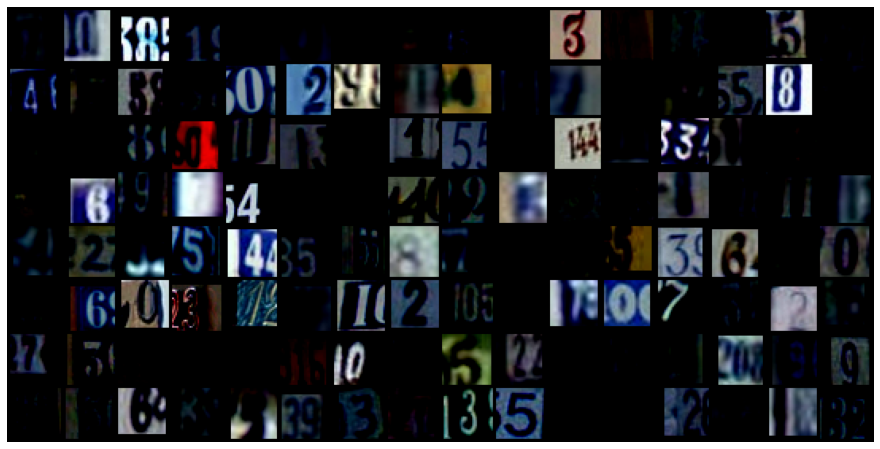

In [ ]:
# for images, _ in dataloaders['train']:
for images, labels in trainloader:
  print("type of labels: ", type(labels))
  print("images shape: ", images.shape)
  plt.figure(figsize=(16,8))
  plt.axis("off")
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print( device )

cuda:0


In [ ]:
model = models.resnet50(weights = ResNet50_Weights.DEFAULT).to(device)

# for param in model.parameters():
#   param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 32),
    nn.ReLU(),
    nn.Linear(32, 10).to(device)
)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters())
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#@title
# def train_model(model, criterion, optimizer, num_epochs=3):
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch+1, num_epochs))
#         print('-' * 10)

#         for phase in ['train', 'validation']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 outputs = model(inputs.cuda())
#                 # print("model outputs: ", outputs)
#                 loss = criterion(outputs, labels)

#                 if phase == 'train':
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                 _, preds = torch.max(outputs, 1)
#                 # print("preds: ", preds)
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / (image_datasets[phase])
#             epoch_acc = running_corrects.double() / (image_datasets[phase])

#             print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
#                                                         epoch_loss,
#                                                         epoch_acc))
#     return model

In [ ]:
def train_model(model, criterion, optimizer, num_epochs):
  losses = []
  running_loss = 0

  # for i, inp in enumerate(dataloaders["train"]):
  #     inputs, labels = inp
  #     print("labels", labels)

  for epoch in range(num_epochs):
    # for i, inp in enumerate(dataloaders["train"]):
    for i, inp in enumerate(trainloader):

      # print("inp:", inp)
      # print("type of inp:", type(inp))
      # print(inp[0].shape)

      inputs, labels = inp
      # print(inputs.shape, labels.shape)
      # print("label type:", type(labels))
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      # print("sss", inputs.shape)
      outputs = model(inputs)
      labels = labels.squeeze()
      # print(labels)
      loss = criterion(outputs, labels)

      losses.append(loss.item())

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if i%100 == 0 and i > 0:
        print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
        running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
  print('Training Done')

In [ ]:
len(train)

In [ ]:
train_model(model.cuda(), criterion, optimizer, num_epochs=15)
# train_model(model, criterion, optimizer, num_epochs=1)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to("cuda"), labels.to("cuda")
    outputs = model(images)

    # print(outputs.data)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

print("Acc: ", 100*(correct/total), "%")

Acc:  95.8397357098955 %


In [ ]:
val_img_path = "gdrive/My Drive/Colab Notebooks/test3.jpg"
val_img = Image.open(val_img_path)
# plt.imshow(val_img)

# resize all to (32,32) for network to work (https://stackoverflow.com/questions/69118647/how-to-change-cnn-model-when-reducing-image-size)
c_c = torchvision.transforms.functional.resize(val_img, 32)

img = transform_test(c_c)
img = img.unsqueeze(0)
img = img.to("cuda")

# print(type(c_c))
plt.imshow(c_c)

with torch.no_grad():
  model.eval()
  output = model(img)
  print(output.data)
  index = output.data.cpu().numpy().argmax()
  
  print(index)


In [ ]:
torch.save(model.state_dict(), "gdrive/My Drive/Colab Notebooks/fine_model_path.pt")